In [1028]:
import os
import pandas as pd
import numpy as np
import math
import wbj
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')

In [1029]:
#def jackknife(x, func):
    # Jackknife estimate of the estimated parameter, takes the numpy array x and uses estimator fu$
#    n = len(x)
#    idx = np.arange(n)
#    return np.sum(func(x[idx!=i]) for i in range(n))/float(n)

#def jackknife_var(x, func):
    # Jackknife estimate of the variance of the estimator func
#    n = len(x)
#    idx = np.arange(n)
#    j_est = jackknife(x, func)
#    return (n-1)/(n + 0.0) * np.sum((func(x[idx!=i]) - j_est)**2.0 for i in range(n))

def make_out_str(a_list):
    b_str=''
    for x in a_list:
        b_str+=str(x)+'\t'
    return b_str[:-1]

In [1030]:
def get_estimates(file_dict):
    b_dict={}
    for ind in file_dict.keys():
        file_list = file_dict[ind]
        b_dict.update({ind: get_res(get_count_list(file_list))})
    return b_dict


def str_to_ints(a_d):
    m0 = int(a_d[0])
    m1 = int(a_d[1])
    m2 = int(a_d[2])
    m3 = int(a_d[3])
    m4 = int(a_d[4])
    m5 = int(a_d[5])
    return (m0,m1,m2,m3,m4,m5)

    
def get_count_list(file_list):
    count_list = []
    for f in file_list:
        with open(inPATH+f,'r') as myfile:
            for a_l in myfile:
                d = a_l.split()
                counts = str_to_ints(d[1:])
                if sum(counts)>0:
                    count_list.append(counts)
    return count_list


def calc_props(in_tuple):
    n1,n2,n3,n4,n5,n6 = in_tuple
    n_tot = 1.0*sum(in_tuple)
    n_tot_transition = 1.0*sum(in_tuple[::2])
    n_tot_transversion = 1.0*sum(in_tuple[::-2])
    prop_derived_total = (n3+n4)/n_tot
    prop_derived_transition = n3/n_tot_transition # proportion of transition heterozygotes that are derived
    prop_derived_transversion = n4/n_tot_transversion # proportion of transversion heterozygotes that are derived
    return [prop_derived_total, prop_derived_transition, prop_derived_transversion]

def get_res(raw_data):
    obs_d = [] # create empty list of length = 6
    for i in range(len(raw_data[0])):
        obs_d.append(0)
    for a_tuple in raw_data:
        for i in range(len(a_tuple)):
            obs_d[i] += a_tuple[i] # sum counts of cats across all windows
    [obs_prop_der, obs_prop_der_transition, obs_prop_der_transversion] = calc_props(obs_d)
    l_prop_der = []
    l_prop_der_transition = []
    l_prop_der_transversion = []
    num_sites = []
    g = 0
    n = 0
    for a_t in raw_data:
        if sum(a_t)>0:
            g += 1
            n += sum(a_t)
            local_tuple = (obs_d[0]-a_t[0], obs_d[1]-a_t[1], obs_d[2]-a_t[2], obs_d[3]-a_t[3], obs_d[4]-a_t[4], obs_d[5]-a_t[5])
            [prop_der, prop_der_transition, prop_der_transversion] = calc_props(local_tuple)
            l_prop_der.append(prop_der)
            l_prop_der_transition.append(prop_der_transition)
            l_prop_der_transversion.append(prop_der_transversion)
            num_sites.append(sum(a_t))
    b_res = [wbj.get_WBJ_mean_var(g,n,obs_prop_der,l_prop_der,num_sites)]
    b_res.append(wbj.get_WBJ_mean_var(g,n,obs_prop_der_transition,l_prop_der_transition,num_sites))
    b_res.append(wbj.get_WBJ_mean_var(g,n,obs_prop_der_transversion,l_prop_der_transversion,num_sites))
    return b_res

In [1031]:
inPATH = 'DIR_counts_per_5cm/'
outPATH = 'DIR_estimates/'
anchor_sample_list=['sf12','SIII','Bichon','Neanderthal','flo011','LBK','Loschbour','Kotias','UstIshim']


In [1032]:
# Or specify individually
anchor = 'flo011'

Get a list of all the count files for your chosen anchor

In [1033]:
temp = [x for x in os.listdir(inPATH)]
anchor_filter = filter(lambda a: anchor+'_vs' in a, temp)
anchor_list = list(anchor_filter)

Build a dict with all recent inds as keys

In [1034]:
all_files_dict={}
for x in anchor_list:
    if x[:len('chr')]=='chr':
        d = x.split('_')
        recentind = d[3][:-len('-txt')]
        if not recentind in all_files_dict.keys():
            all_files_dict.update({recentind:[]}) 
        all_files_dict[recentind].append(x)

Check to ensure each sample has counts for all 22 autosomes

In [1035]:
for ind in all_files_dict.keys():
    if not len(all_files_dict[ind])==22:
        print(ind, len(all_files_dict[ind]))
        print(sorted(all_files_dict[ind]))
        print('Counts not present for all 22 autosomes')

For each individual, calculate obs_mean, wbj_mean & wbj_var for proportion derived, proportion derived of anchor transitions, and proportion derived of anchor transversions.

In [1036]:
a_res_dict = get_estimates(all_files_dict)
# change name of sample "rom002_rom003_rom057_rom058" to "rom057_rom58"
value = a_res_dict.pop("ro")
a_res_dict.update({"rom057_rom058": value})

Write results to outfiles, 3 per anchor

In [1037]:
props_der = open(outPATH+anchor+'_prop_der.res','w')
props_der_transition = open(outPATH+anchor+'_prop_der_transition.res','w')
props_der_transversion = open(outPATH+anchor+'_prop_der_transversion.res','w')
header = '\t'.join(['sample','obs_mean','wbj_mean','wbj_var'])+'\n'
props_der.write(header)
props_der_transition.write(header)
props_der_transversion.write(header)

for ind in a_res_dict.keys():
    [prop_der, prop_der_transition, prop_der_transversion] = a_res_dict[ind]
    props_der.write('\t'.join([ind, prop_der[0], prop_der[1], prop_der[2]])+'\n')
    props_der_transition.write('\t'.join([ind, prop_der_transition[0], prop_der_transition[1], prop_der_transition[2]])+'\n')
    props_der_transversion.write('\t'.join([ind, prop_der_transversion[0], prop_der_transversion[1], prop_der_transversion[2]])+'\n')
props_der.close()
props_der_transition.close()
props_der_transversion.close()

## Plotting results
### First plot total proportion derived

In [1038]:
# Global toggle to save / not-save figures
isSaveFigures = True

# adjust some font params
plt.rcParams.update({'font.size': 12})
plt.rc('legend',fontsize='12')

In [1039]:
################################################

In [1040]:
df1 = pd.read_csv(outPATH+anchor+'_prop_der.res', sep="\t")
df1['wbj_errors']=1.96*np.sqrt(df1['wbj_var'])
df1_sorted = df1.sort_values(['wbj_mean'], ascending=False)

df2 = pd.read_csv(outPATH+anchor+'_prop_der_transversion.res', sep="\t")
df2['wbj_errors']=1.96*np.sqrt(df2['wbj_var'])
df2_sorted = df2.sort_values(['wbj_mean'], ascending=False)

In [1041]:
#ax = df1_sorted.plot(kind='bar', x='sample', y='wbj_mean', legend=False, yerr='wbj_errors', capsize=1, rot=75)
#plt.title('Proportion derived with anchor = {}'.format(anchor), pad=20)
#plt.ylabel("Mean proportion derived (all sites)")
#plt.xlabel("Sample")
#plt.ylim([0.30, 0.40])
#plt.tight_layout()
#if isSaveFigures:
#    plt.savefig('DIR_plots/'+anchor+'_prop_der_Scandis.pdf')

In [1042]:
#ax = df1_sorted.plot(kind='scatter', x='wbj_mean', y='sample', legend=False, xerr='wbj_errors',c=df1_sorted['Group'].map(colors))

#plt.title('Proportion derived with anchor = {}'.format(anchor), pad=20)
#plt.xlabel("Mean proportion derived (all sites)", labelpad=20)
#plt.ylabel("Sample", labelpad=20)
#plt.xlim([0.32, 0.42])
#for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
#    item.set_fontsize(16)
#for item in (ax.get_xticklabels() + ax.get_yticklabels()):
#    item.set_fontsize(12)     
#plt.tight_layout()

### Article figure

### Add individuals to populations to aid visualization

In [1043]:
groups = {"buk002":"Romania","buk002dr":"Romania","buk003":"Romania","buk003dr":"Romania","buk004":"Romania","buk004dr":"Romania","buk010":"Romania","buk010dr":"Romania","buk012":"Romania","buk013":"Romania","buk018":"Romania","buk019":"Romania","buk019dr":"Romania","buk022":"Romania","buk022dr":"Romania","buk023":"Romania","buk023dr":"Romania","buk029":"Romania","buk029dr":"Romania","buk031":"Romania","buk031dr":"Romania","buk033":"Romania","buk033dr":"Romania","buk040":"Romania",
         "rom057_rom058":"Romania","rom011":"Romania","rom046":"Romania","rom046dr":"Romania","rom047":"Romania","rom047dr":"Romania","rom061":"Romania","rom066":"Romania",
         "lbk101":"Poland","lbk102":"Poland","lbk104":"Poland","lbk138":"Poland",
         "poz120":"Poland","poz120dr":"Poland","poz121":"Poland","poz177":"Poland","poz236":"Poland","poz236dr":"Poland","poz252":"Poland","poz264":"Poland","poz275":"Poland","poz297":"Poland","poz297dr":"Poland","poz375":"Poland","poz503":"Poland","poz503dr":"Poland",
         "ukr005":"Ukraine","ukr033":"Ukraine","ukr040":"Ukraine","ukr087":"Ukraine","ukr102":"Ukraine","ukr104":"Ukraine","ukr108":"Ukraine","ukr111":"Ukraine","ukr112":"Ukraine","ukr113":"Ukraine","ukr116":"Ukraine","ukr117":"Ukraine","ukr123":"Ukraine","ukr125":"Ukraine","ukr144":"Ukraine","ukr147":"Ukraine","ukr149":"Ukraine","ukr158":"Ukraine","ukr159":"Ukraine","ukr160":"Ukraine","ukr161":"Ukraine","ukr162":"Ukraine"}

df1_sorted['Groups'] = df1_sorted['sample'].map(groups)
df2_sorted['Groups'] = df2_sorted['sample'].map(groups)


## Add age column for later ordering during plotting

In [1044]:
ages = {"buk002":6570,"buk002dr":6570,"buk003":6850,"buk003dr":6850,"buk004":5160,"buk004dr":5160,"buk010":6510,"buk010dr":6510,"buk012":6630,"buk013":6520,"buk018":5950,"buk019":5980,"buk019dr":5980,"buk022":5980,"buk022dr":5980,"buk023":5960,"buk023dr":5960,"buk029":5790,"buk029dr":5790,"buk031":5960,"buk031dr":5960,"buk033":5800,"buk033dr":5800,"buk040":6080,
         "rom057_rom058":6635,"rom011":5880,"rom046":5780,"rom046dr":5780,"rom047":5420,"rom047dr":5420,"rom061":8800,"rom066":8200,
         "lbk101":5330,"lbk102":5330,"lbk104":5330,"lbk138":5330,
         "poz120":5375,"poz120dr":5375,"poz121":5370,"poz177":5160,"poz236":5329,"poz236dr":5329,"poz252":5605,"poz264":5050,"poz275":5040,"poz297":7360,"poz297dr":7360,"poz375":5032,"poz503":8310,"poz503dr":8310,
         "ukr005":6870,"ukr033":6230,"ukr040":5990,"ukr087":6300,"ukr102":8080,"ukr104":5340,"ukr108":7630,"ukr111":6370,"ukr112":6030,"ukr113":6380,"ukr116":6010,"ukr117":6730,"ukr123":5910,"ukr125":9840,"ukr144":6620,"ukr147":6320,"ukr149":6170,"ukr158":6760,"ukr159":6640,"ukr160":6810,"ukr161":6650,"ukr162":6320}
        
df1_sorted['Ages'] = df1_sorted['sample'].map(ages)
df2_sorted['Ages'] = df2_sorted['sample'].map(ages)        
        

In [1045]:
# separate dataframes into blunt end and dr versions
def drop_rows_with_suffix(df, column_name, suffix):
    return df[~df[column_name].str.endswith(suffix)]

def drop_rows_without_suffix(df, column_name, suffix):
    return df[df[column_name].str.endswith(suffix)]

df1_sorted = drop_rows_without_suffix(df1_sorted, 'sample', 'dr') # drop blunt end individuals
df2_sorted = drop_rows_with_suffix(df2_sorted, 'sample', 'dr') # drop damage repair individuals


In [1046]:
# create unique colours for each sample
unique = df2_sorted["Groups"].unique()
palette = {'Ukraine': (0, 0, 0),
 'Romania': (218/255,112/255,214/255),
 'Poland': (255/255,128/255,0)}

#palette = dict(zip(unique, sns.color_palette("Set1",n_colors=len(unique))))

group_order=['Ukraine','Romania','Poland']

In [1059]:
region = 'Poland'
data1_in = df1_sorted[df1_sorted['Groups'] == region]
data2_in = df2_sorted[df2_sorted['Groups'] == region]
idx = group_order.index(region)

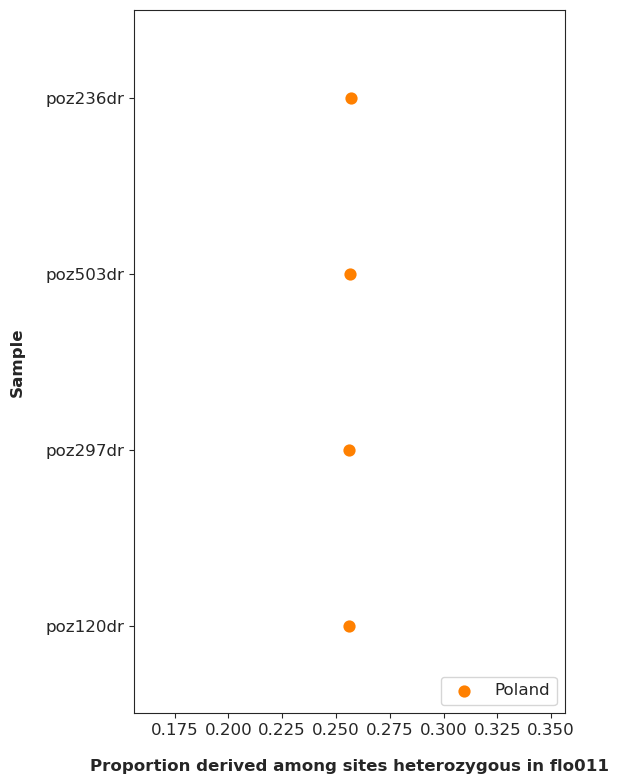

In [1060]:
fig, ax = plt.subplots(figsize=(6,8))

# really hacky way to do error bars - plotting under the sns plot with invisible markers
a = data1_in['wbj_mean']
b = data1_in['sample']
c = data1_in['wbj_errors']
ax.errorbar(a, b, xerr=c, fmt='none', ecolor='grey', zorder=0)

ax = sns.pointplot(x='wbj_mean', y='sample', data=data1_in, hue='Groups', hue_order=group_order[idx:idx+1], join=False, palette=palette, zorder=1)
ax.ticklabel_format(style='plain', axis='x')

plt.xlabel("Proportion derived among sites heterozygous in {}".format(anchor),fontweight ='bold', size=12, labelpad=15)
plt.ylabel("Sample",fontweight ='bold', size=12, labelpad=15)
plt.legend(loc='lower right')
lower, upper = [data1_in['wbj_mean'].mean()-0.1, data1_in['wbj_mean'].mean()+0.1]
ax.set_xlim(lower, upper)
#ax.get_legend().remove()
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Anchor_{}_dr_{}.png'.format(anchor, region), dpi=300)

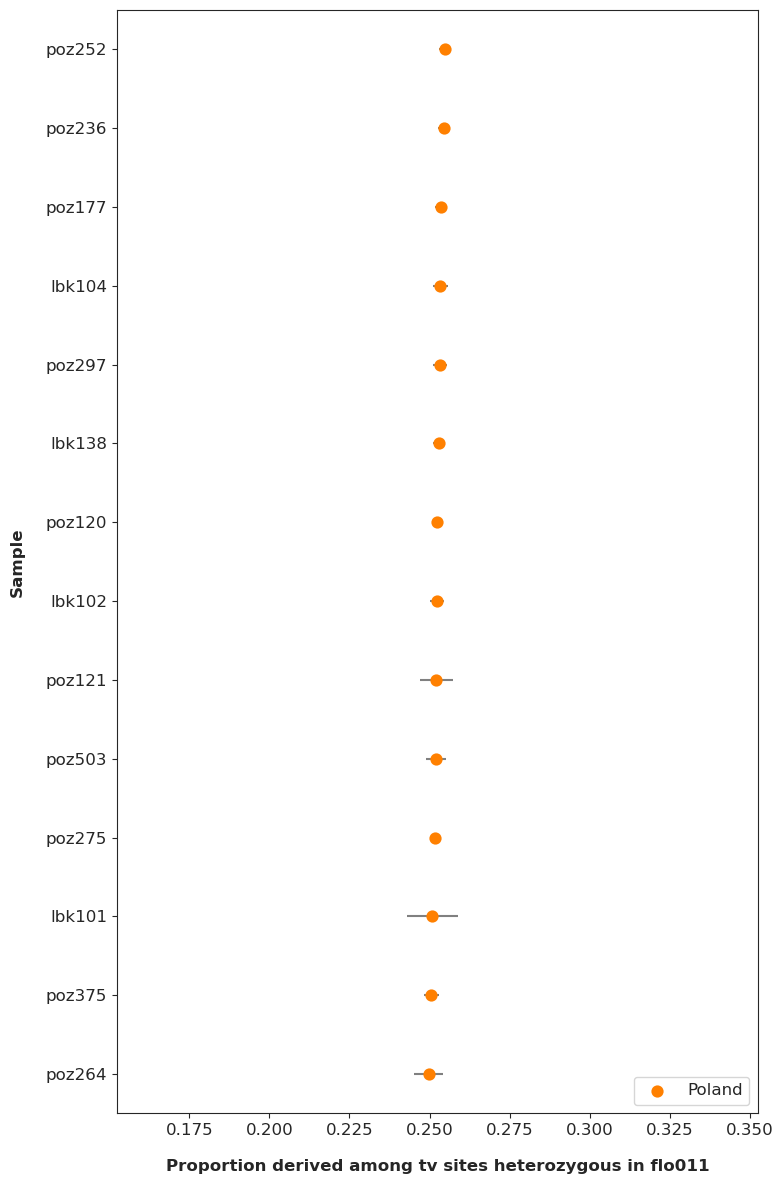

In [1061]:
fig, ax = plt.subplots(figsize=(8,12))

# hacky error bars - plotting under the sns plot with invisible markers
a = data2_in['wbj_mean']
b = data2_in['sample']
c = data2_in['wbj_errors']
ax.errorbar(a, b, xerr=c, fmt='none', ecolor='grey', zorder=0)

ax = sns.pointplot(x='wbj_mean', y='sample', data=data2_in, hue='Groups', hue_order=group_order[idx:idx+1], join=False, palette=palette, zorder=1)
ax.ticklabel_format(style='plain', axis='x')

plt.xlabel("Proportion derived among tv sites heterozygous in {}".format(anchor),fontweight ='bold', size=12, labelpad=15)
plt.ylabel("Sample",fontweight ='bold', size=12, labelpad=15)
plt.legend(loc='lower right')
lower, upper = [data2_in['wbj_mean'].mean()-0.1, data2_in['wbj_mean'].mean()+0.1]
ax.set_xlim(lower, upper)
#ax.get_legend().remove()
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Anchor_{}_be_{}.png'.format(anchor, region), dpi=300)
                             

## Repeat but sort by time

In [1062]:
data1_in = data1_in.sort_values(['Ages'], ascending=False)
data2_in = data2_in.sort_values(['Ages'], ascending=False)

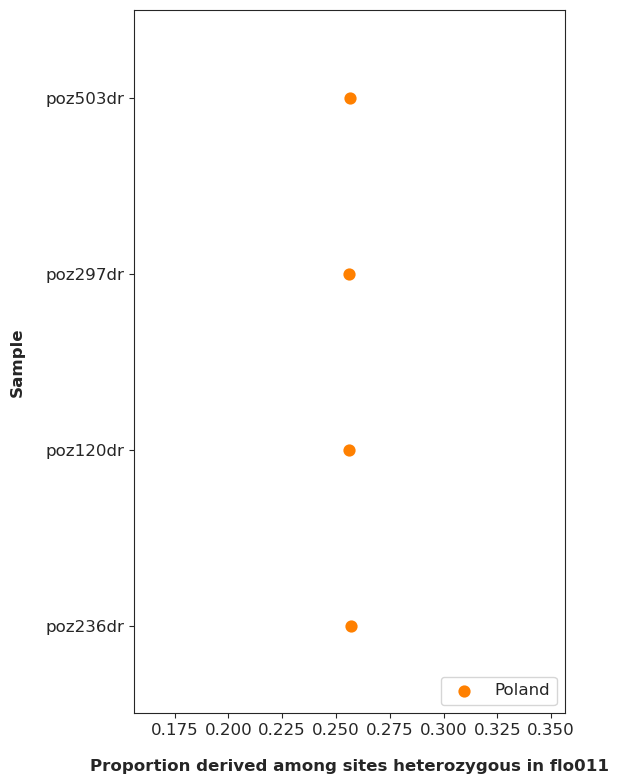

In [1063]:
fig, ax = plt.subplots(figsize=(6,8))

a = data1_in['wbj_mean']
b = data1_in['sample']
c = data1_in['wbj_errors']
ax.errorbar(a, b, xerr=c, fmt='none', ecolor='grey', zorder=0)

ax = sns.pointplot(x='wbj_mean', y='sample', data=data1_in, hue='Groups', hue_order=group_order[idx:idx+1], join=False, palette=palette, zorder=1)
ax.ticklabel_format(style='plain', axis='x')

plt.xlabel("Proportion derived among sites heterozygous in {}".format(anchor),fontweight ='bold', size=12, labelpad=15)
plt.ylabel("Sample",fontweight ='bold', size=12, labelpad=15)
plt.legend(loc='lower right')
lower, upper = [data1_in['wbj_mean'].mean()-0.1, data1_in['wbj_mean'].mean()+0.1]
ax.set_xlim(lower, upper)
#ax.get_legend().remove()
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Anchor_{}_dr_{}_AgeSorted.png'.format(anchor, region), dpi=300)
    

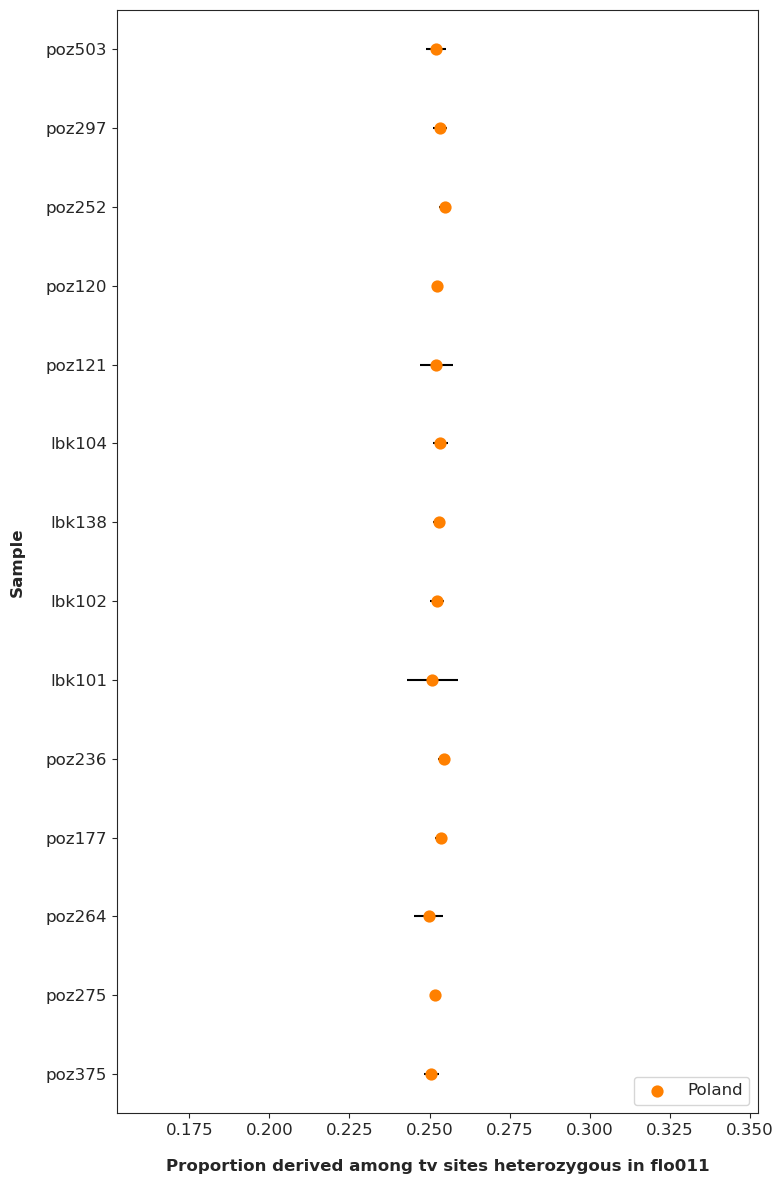

In [1064]:
fig, ax = plt.subplots(figsize=(8,12))

# really hacky way to do error bars - plotting over the top of the sns plot with invisible markers
a = data2_in['wbj_mean']
b = data2_in['sample']
c = data2_in['wbj_errors']
ax.errorbar(a, b, xerr=c, fmt='none', ecolor='black', zorder=0)

ax = sns.pointplot(x='wbj_mean', y='sample', data=data2_in, hue='Groups', hue_order=group_order[idx:idx+1], join=False, palette=palette, zorder=1)
ax.ticklabel_format(style='plain', axis='x')

plt.xlabel("Proportion derived among tv sites heterozygous in {}".format(anchor),fontweight ='bold', size=12, labelpad=15)
plt.ylabel("Sample",fontweight ='bold', size=12, labelpad=15)
plt.legend(loc='lower right')
lower, upper = [data2_in['wbj_mean'].mean()-0.1, data2_in['wbj_mean'].mean()+0.1]
ax.set_xlim(lower, upper)
#ax.get_legend().remove()
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Anchor_{}_be_{}_AgeSorted.png'.format(anchor, region), dpi=300)
    